In [1]:
import numpy as np
import hmvec as hm
import matplotlib.pyplot as plt
import matplotlib

In [2]:
#Plot settings
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 'xx-large'
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.titlesize'] = 'xx-large'

## Setting Up

First, we setup our grid and initialize our halo model. Since this on a shared node on Cori, the (z,m,k) grid we set up is fairly coarse.

In [3]:
#Setup Grid
Nz = 200                                 # num of redshifts
Nm = 200                                 # num of masses
Nk = 1000                                # num of wavenumbers
redshifts = np.linspace(0.01, 10, Nz)             
masses = np.geomspace(1.0e6, 1.0e15, Nm)          
ks = np.geomspace(1.0e-3, 100.0, Nk)              # wavenumbers
ells = np.linspace(10, 2000, 200)

In [4]:
#Initialize Halo Model 
hcos = hm.HaloModel(redshifts, ks, ms=masses)

Next, set up the parameters for the CIB model we want. We'll be using Planck 2013 values. We can also give different parameter values (e.g. a dictionary of new values for some/all of the parameters); see 'set_cibParams' documentation for details.

In [5]:
#Set CIB Parameters
hcos.set_cibParams('planck13')

## Frequencies

We need to create a 2x2 array of frequencies. The first axis contains the frequencies to be auto/cross-correlated. The second axis contains the endpoints of a range of frequencies (as in a bandpass).

If you can provide a 1D array containing a single frequency/bandpass, it will assume you want an autocorrelation.

In [6]:
#Autocorrelation: 1 Freq
autofreq = np.array([545e9], dtype=np.double)          

#Autocorrelation: Bandpass
autoband = np.array([540e9, 550e9], dtype=np.double)          

#Cross-Correlation: 1 Freq
crossfreq = np.array([[545e9],[353e9]], dtype=np.double)  

#Cross-Correlation: Bandpass
crossband = np.array([[540e9, 550e9],[347e9, 359e9]], dtype=np.double)   

Let's just stick with a single frequency autocorrelation for now.

## Calculations

Let's do all of the calculations with both the Tinker and Jiang subhalo mass functions. The default in this notebook will be the Jiang (note that this is not the default value for the power functions, which choose Tinker by default).

In [ ]:
#Get 3D Power Spectra P(z,k): Tinker
Pjj_tot_tink = hcos.get_power("cib", "cib", nu_obs=autofreq, satmf = 'tinker')  
Pjj_1h_tink = hcos.get_power_1halo("cib", "cib", nu_obs=autofreq, satmf = 'tinker')  
Pjj_2h_tink = hcos.get_power_2halo("cib", "cib", nu_obs=autofreq, satmf = 'tinker')  
Pjj_cen = hcos.get_power("cib", "cib", nu_obs=autofreq, subhalos=False)  # no satellites

In [ ]:
#Get 3D Power Spectra P(z,k): Jiang
Pjj_tot = hcos.get_power("cib", "cib", nu_obs=autofreq, satmf = 'jiang')  
Pjj_1h = hcos.get_power_1halo("cib", "cib", nu_obs=autofreq, satmf = 'jiang')  
Pjj_2h = hcos.get_power_2halo("cib", "cib", nu_obs=autofreq, satmf = 'jiang')  
Pjj_cen = hcos.get_power("cib", "cib", nu_obs=autofreq, subhalos=False, satmf = 'jiang')  # no satellites

In [9]:
#Limber Integrals: Tinker
C_tot_tink, dcdz_tot_tink = hcos.C_ii(ells, redshifts, ks, Pjj_tot_tink, dcdzflag=True)
C_1h_tink, dcdz_1h_tink = hcos.C_ii(ells, redshifts, ks, Pjj_1h_tink, dcdzflag=True)
C_2h_tink, dcdz_2h_tink = hcos.C_ii(ells, redshifts, ks, Pjj_2h_tink, dcdzflag=True)
C_cen, dcdz_cen = hcos.C_ii(ells, redshifts, ks, Pjj_cen, dcdzflag=True)

In [10]:
#Limber Integrals: Jiang
C_tot, dcdz_tot = hcos.C_ii(ells, redshifts, ks, Pjj_tot, dcdzflag=True)
C_1h, dcdz_1h = hcos.C_ii(ells, redshifts, ks, Pjj_1h, dcdzflag=True)
C_2h, dcdz_2h = hcos.C_ii(ells, redshifts, ks, Pjj_2h, dcdzflag=True)
C_cen, dcdz_cen = hcos.C_ii(ells, redshifts, ks, Pjj_cen, dcdzflag=True)

## Plots

Let's first look at the $C$'s with the centrals and the satellites.

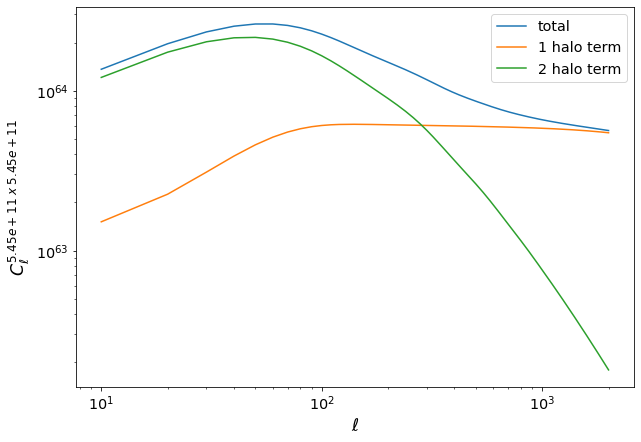

In [11]:
plt.figure(figsize=(10,7))

#Plot C's
plt.loglog(ells, C_tot, label='total')
plt.loglog(ells, C_1h, label='1 halo term')
plt.loglog(ells, C_2h, label='2 halo term')

#Gravy
plt.xlabel(r'$\ell$')
plt.ylabel(rf'$C^{{ {autofreq[0]:.2e} \;x\; {autofreq[0]:.2e} }}_\ell$')
plt.legend();

# plt.savefig('cii_1h2h_jiang.pdf', dpi=900, bbox_inches='tight');

Now let's see the total $C$ without any satellites. Note the difference in the magnitude of the power with and without the satellites. The units are not established yet.

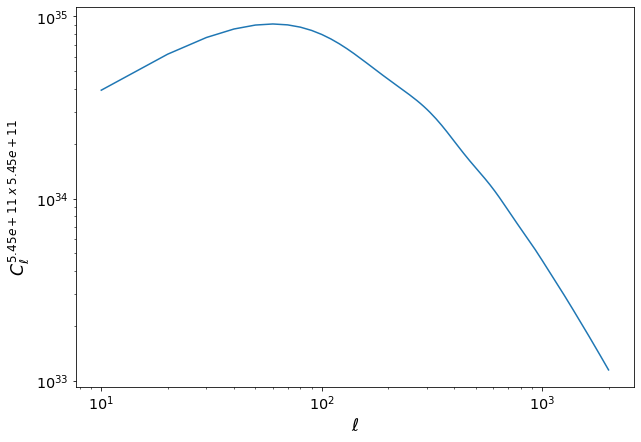

In [12]:
plt.figure(figsize=(10, 7))

#Plot C without Satellites
plt.loglog(ells, C_cen)

#Gravy
plt.xlabel(r'$\ell$')
plt.ylabel(rf'$C^{{ {autofreq[0]:.2e} \;x\; {autofreq[0]:.2e} }}_\ell$');

Now let's look at $dC/dz$ with the satellites.

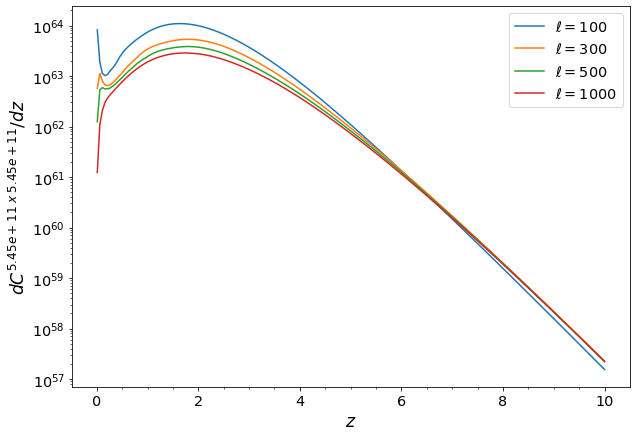

In [13]:
#Plot dC/dz With Satellites
test_ells = np.array([100, 300, 500, 1000])
plt.figure(figsize=(10,7))
for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Spectra
    plt.semilogy(redshifts, dcdz_tot[:, i], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.ylabel(rf'$dC^{{ {autofreq[0]:.2e} \;x\; {autofreq[0]:.2e} }} / dz$')
    plt.legend()
    plt.minorticks_on();

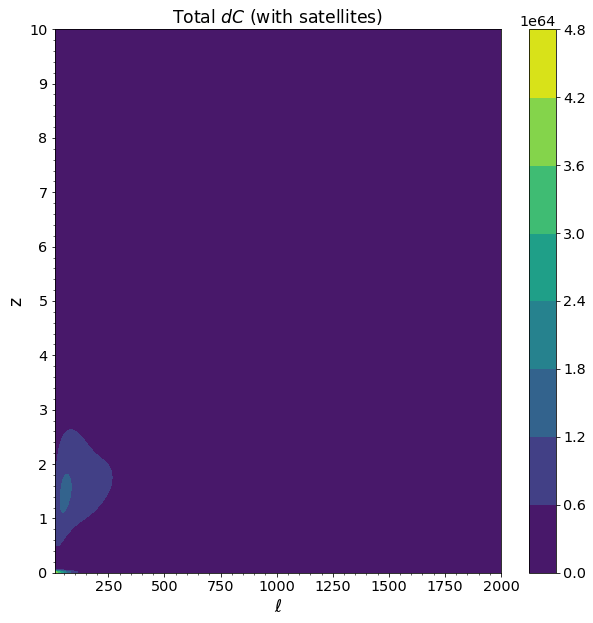

In [14]:
#Setup
plt.figure(figsize=(10,10))

#Plots
plt.contourf(ells, redshifts, dcdz_tot)

#Gravy
plt.colorbar()
plt.xlabel(r'$\ell$')
plt.ylabel('z')
plt.title(r'Total $dC$ (with satellites)')

#Ticks
ax = plt.gca()
ax.set_yticks(np.arange(0,11))
plt.minorticks_on()

# plt.savefig('dc_jiang.pdf', dpi=900, bbox_inches='tight');

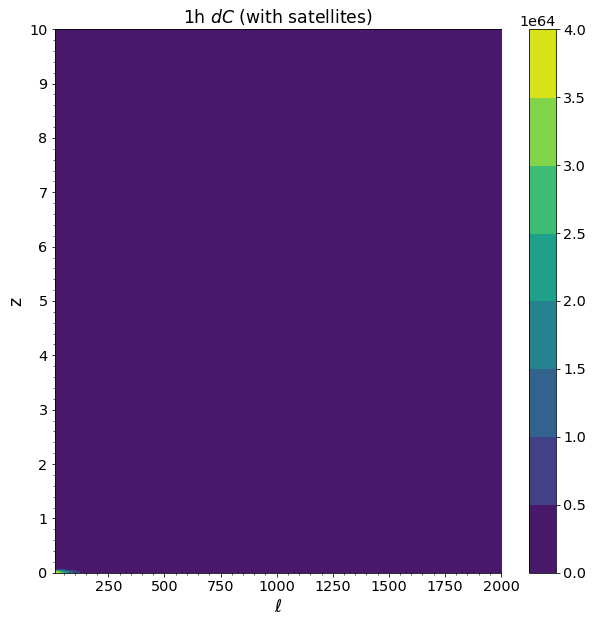

In [15]:
#Setup
plt.figure(figsize=(10,10))

#Plots
plt.contourf(ells, redshifts, dcdz_1h)

#Gravy
plt.colorbar()
plt.xlabel(r'$\ell$')
plt.ylabel('z')
plt.title(r'1h $dC$ (with satellites)')

#Ticks
ax = plt.gca()
ax.set_yticks(np.arange(0,11))
plt.minorticks_on()

# plt.savefig('dc_1h_jiang.pdf', dpi=900, bbox_inches='tight');

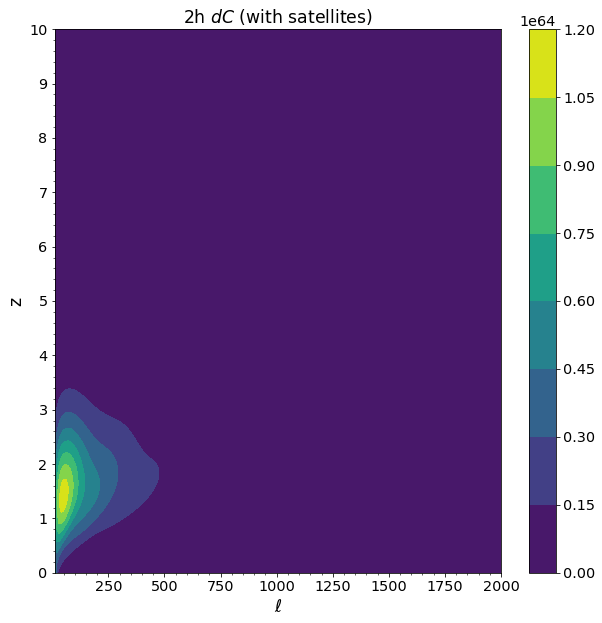

In [16]:
#Setup
plt.figure(figsize=(10,10))

#Plots
plt.contourf(ells, redshifts, dcdz_2h)

#Gravy
plt.colorbar()
plt.xlabel(r'$\ell$')
plt.ylabel('z')
plt.title(r'2h $dC$ (with satellites)')

#Ticks
ax = plt.gca()
ax.set_yticks(np.arange(0,11))
plt.minorticks_on();

# plt.savefig('dc_2h_jiang.pdf', dpi=900, bbox_inches='tight');

And $dC/dz$ without the satellites.

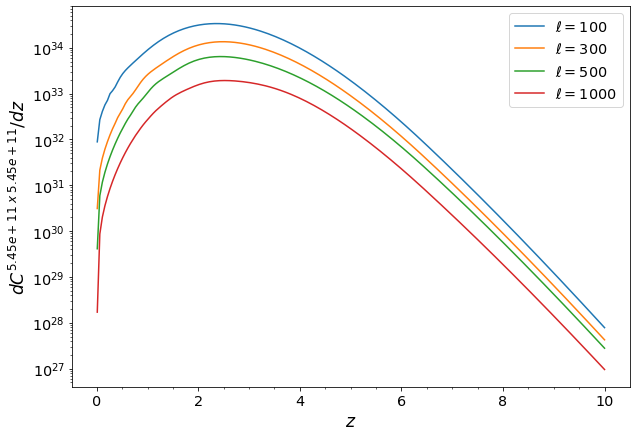

In [17]:
#Plot dC/dz With Satellites
test_ells = np.array([100, 300, 500, 1000])
plt.figure(figsize=(10,7))
for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Spectra
    plt.semilogy(redshifts, dcdz_cen[:, i], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.ylabel(rf'$dC^{{ {autofreq[0]:.2e} \;x\; {autofreq[0]:.2e} }} / dz$')
    plt.legend()
    plt.minorticks_on();